# Twitter Sentiment Analysis using Recurrent Neural Networks and LSTM

### 1. Import python packages (NLTK, SK-Learn, TensorFlow)

In [23]:
import io
import os
import re
import shutil
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

### 2. Load Tweets into a dataframe from dataset

In [2]:
DATASET_COLUMNS = ["label", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

tweets = pd.read_csv('./twitter.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

tweets.head()

,label,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### 3. Pre-Processing

#### 3.1 Set Postive and Negative Labels

In [3]:
tweets = tweets[['text','label']]
tweets['label'][tweets['label']==4]=1

tweets_pos = tweets[tweets['label'] == 1]
tweets_neg = tweets[tweets['label'] == 0]

#### 3.2 Select a subset of postive and negative tweets

In [4]:
tweets_pos = tweets_pos.iloc[:int(20000)]
tweets_neg = tweets_neg.iloc[:int(20000)]

tweets = pd.concat([tweets_pos, tweets_neg])

In [5]:
len(tweets)

40000

#### 3.3 Initialize varibales and constants for pre-processing and model development

In [6]:
nltk.download('stopwords')
", ".join(stopwords.words('english'))

STOPWORDS = set(stopwords.words('english'))

english_punctuations = string.punctuation
punctuations_list = english_punctuations

vocab_size = 2000
embed_dim=50
MAX_SEQUENCE_LENGTH = 500
lstm_out = 50

regex_tokenizer = RegexpTokenizer(r'\w+')
tokenizer = Tokenizer(num_words=vocab_size)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apoondic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 3.4 Define Data Pre-Processing Functions

In [7]:
def unify_casing(text):
    return text.lower()

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

def tokenize_sentence_to_words(text):
    return regex_tokenizer.tokenize(text)
    
def transform_text(text):
    text = unify_casing(text)
    text = cleaning_stopwords(text)
    text = cleaning_punctuations(text)
    text = cleaning_repeating_char(text)
    text = cleaning_email(text)
    text = cleaning_URLs(text)
    text = cleaning_numbers(text)
    text = tokenize_sentence_to_words(text)
    
    return text

In [8]:
def tokenize_words_to_numeric(sentences):

    tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)
    sequences_matrix = sequence.pad_sequences(sequences, maxlen=500)
    
    return sequences_matrix

#### 3.5 Execute Data Cleaning

In [9]:
tweets['text'] = tweets['text'].apply(lambda text: transform_text(text))

tweets.head()

,text,label
800000,"[love, healthuandpets, u, guys, r, best]",1
800001,"[im, meting, one, besties, tonight, cant, wait...",1
800002,"[darealsunisakim, thanks, twiter, ad, sunisa, ...",1
800003,"[sick, realy, cheap, hurts, much, eat, real, f...",1
800004,"[lovesbroklyn, efect, everyone]",1


#### 3.6 Tokenize words to numeric form | Seperate Inputs and Labels

In [10]:
X = tokenize_words_to_numeric(tweets.text)
y = tweets.label

In [11]:
X.shape

(40000, 500)

#### 3.7 Prepare Training and Test Set

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=2)

### 4. Build RNN model

#### 4.1 Define RNN layers

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU
from sklearn.model_selection import train_test_split



model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length = MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.4))
model.add(GRU(lstm_out, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           100000    
                                                                 
 spatial_dropout1d (Spatial  (None, 500, 50)           0         
 Dropout1D)                                                      
                                                                 
 gru (GRU)                   (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 115402 (450.79 KB)
Trainable params: 115402 (450.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


#### 4.2 Train RNN Model

In [14]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=80, validation_split=0.15)

Epoch 1/5
298/298 [==============================] - 168s 551ms/step - loss: 0.5969 - accuracy: 0.6700 - val_loss: 0.5291 - val_accuracy: 0.7376
Epoch 2/5
298/298 [==============================] - 173s 580ms/step - loss: 0.5132 - accuracy: 0.7495 - val_loss: 0.5237 - val_accuracy: 0.7383
Epoch 3/5
298/298 [==============================] - 124s 416ms/step - loss: 0.4962 - accuracy: 0.7584 - val_loss: 0.5214 - val_accuracy: 0.7388
Epoch 4/5
298/298 [==============================] - 116s 391ms/step - loss: 0.4843 - accuracy: 0.7669 - val_loss: 0.5213 - val_accuracy: 0.7424
Epoch 5/5
298/298 [==============================] - 115s 385ms/step - loss: 0.4764 - accuracy: 0.7687 - val_loss: 0.5234 - val_accuracy: 0.7388


### 5. Model Testing and Inference

#### 5.1 Evaluate the model

In [15]:
accr1 = model.evaluate(X_test,Y_test)

375/375 [==============================] - 13s 36ms/step - loss: 0.5211 - accuracy: 0.7473


#### 5.2 Test few samples

In [16]:
test = ['I love this course!','never go to this bad restraunt anytime']

test = [(lambda x: transform_text(x))(x) for x in test]

test = tokenize_words_to_numeric(test)

In [17]:
model.predict(test)

1/1 [==============================] - 0s 400ms/step


array([[0.24363832, 0.7563617 ],
       [0.9157414 , 0.08425859]], dtype=float32)

#### 5.3 Run Inference

In [18]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = [(lambda x: np.argmax(x))(x) for x in y_pred]

375/375 [==============================] - 13s 33ms/step


### 6. Model Performance

#### 6.1 Confusion Matrix

In [24]:
cm = metrics.confusion_matrix(Y_test, y_pred)

print(cm)

TN, FP, FN, TP = cm.ravel()
TN, FP, FN, TP

[[4409 1600]
 [1432 4559]]


(4409, 1600, 1432, 4559)

In [25]:
df_cm = pd.DataFrame(data=cm, columns=['predict: negative_sentiment', 'predict: positive_sentiment'],
                    index = ['Actual: negative_Sentiment', 'Actual: positive_sentiment'])

df_cm

,predict: negative_sentiment,predict: positive_sentiment
Actual: negative_Sentiment,4409,1600
Actual: positive_sentiment,1432,4559


<Axes: >

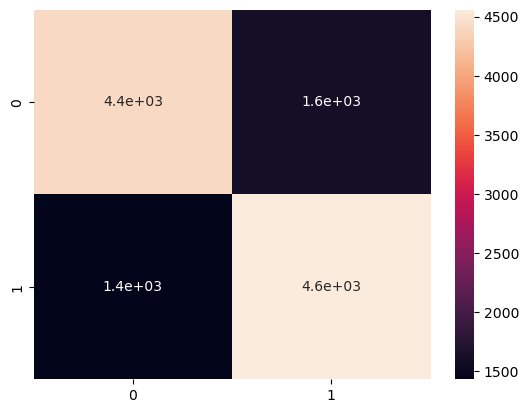

In [26]:
sns.heatmap(cm, annot=True)

#### 6.2 Plot ROC curve

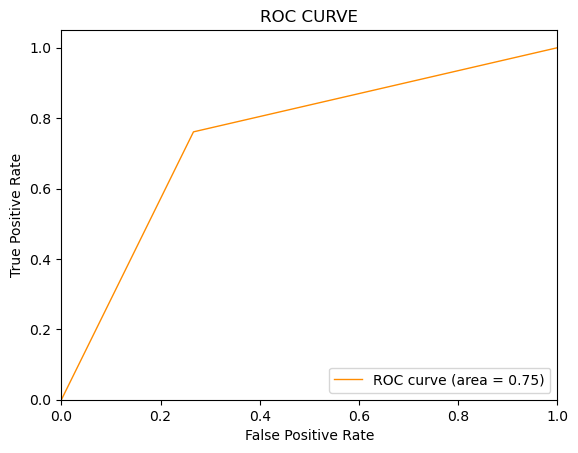

In [28]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Comments Section for reference -- Ignore cells after this

In [ ]:
# tweets['text'] = tweets['text'].str.lower()
# tweets['text'] = tweets['text'].apply(lambda text: cleaning_stopwords(text))
# tweets['text'] = tweets['text'].apply(lambda text: cleaning_punctuations(text))
# tweets['text'] = tweets['text'].apply(lambda text: cleaning_repeating_char(text))
# tweets['text'] = tweets['text'].apply(lambda text: cleaning_email(text))
# tweets['text'] = tweets['text'].apply(lambda text: cleaning_URLs(text))
# tweets['text'] = tweets['text'].apply(lambda text: cleaning_numbers(text))

# import seaborn as sns 
# sns.set(rc={'figure.figsize':(20,8)})
# sns.countplot(tweets, x="wordlen")

# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X)
# vocab_size = len(tokenizer.word_index) + 1
# print("Total words", vocab_size)

# sequences = tokenizer.texts_to_sequences(X)
# sequences_matrix = sequence.pad_sequences(sequences,maxlen=10)

In [ ]:
# history_dict = history.history
# history_dict.keys()

In [ ]:
# import matplotlib.pyplot as plt

# acc = history_dict['accuracy']
# val_acc = history_dict['val_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)

# # "bo" is for "blue dot"
# plt.plot(epochs, loss, 'bo', label='Training loss')
# # b is for "solid blue line"
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

In [ ]:
# plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

# plt.show()